<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/wetsat_geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

						                           Google Colaboratory
						                              PostgreSQL
						                                GitHub	     
						Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
													Code Developed by
													 Carlos Mendez
												  Sebastian Palomino
													Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [35]:
###################################### Artificial Intelligence Frameworks #####################################################
# Geospatial Artificial Intelligence (GeoAI)
%pip install geoai-py
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
# PyTorch Framework
!pip torch torchvision
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily

ERROR: unknown command "torch"


# Import libraries and packages

In [36]:
import geoai
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 585 (delta 11), reused 7 (delta 5), pack-reused 569 (from 3)
Receiving objects: 100% (585/585), 1.41 GiB | 29.09 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Updating files: 100% (246/246), done.


# Import Sentinel-1 Raster Images (VH-VV polarization)

In [9]:
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VH_gamma_dB/"
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VV_gamma_dB/"

# Visualize images from gamma_dB_vh
'''
gamma_dB_vh_tif = [os.path.join(vh_path, f) for f in os.listdir(vh_path) if f.endswith('.tif')]
for gamma_dB_vh_files in gamma_dB_vh_tif:
    with rasterio.open(gamma_dB_vh_files) as src:
        raster_gamma_dB_vh = src.read(1)
        plt.figure(figsize=(8, 6))
        plt.imshow(raster_gamma_dB_vh, cmap='gray')
        plt.title(f"File: {os.path.basename(gamma_dB_vh_files)}")
        plt.axis('off')
        plt.show()
'''
# Visualize images from gamma_dB_vv
'''
gamma_dB_vv_tif = [os.path.join(vv_path, f) for f in os.listdir(vv_path) if f.endswith('.tif')]
# Visualize images from gamma_dB_vh
for gamma_dB_vv_files in gamma_dB_vv_tif:
    with rasterio.open(gamma_dB_vv_files) as src:
        raster_gamma_dB_vv = src.read(1)
        plt.figure(figsize=(8, 6))
        plt.imshow(raster_gamma_dB_vv, cmap='gray')
        plt.title(f"File: {os.path.basename(gamma_dB_vv_files)}")
        plt.axis('off')
        plt.show()
'''

'\ngamma_dB_vv_tif = [os.path.join(vv_path, f) for f in os.listdir(vv_path) if f.endswith(\'.tif\')]\n\n# Visualize images from gamma_dB_vh\nfor gamma_dB_vv_files in gamma_dB_vv_tif:\n    with rasterio.open(gamma_dB_vv_files) as src:\n        raster_gamma_dB_vv = src.read(1)\n        plt.figure(figsize=(8, 6))\n        plt.imshow(raster_gamma_dB_vv, cmap=\'gray\')\n        plt.title(f"File: {os.path.basename(gamma_dB_vv_files)}")\n        plt.axis(\'off\')\n        plt.show()\n'

In [10]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
assert vh_images.shape == vv_images.shape, "The dimensions and size of VH-VV polarizations are equal"

# Combine the VH-VV polarization with the same size and dimensions
X = np.stack([vh_images, vv_images], axis=-1)  # (n_images)

System recognized 29 images VH polarization with size (1121, 967) each one.
System recognized 29 images VV polarization with size (1121, 967) each one.


# Import points (.shp) with labels and marks

The coordinates of the .shp are: [(497798.553999908, 2843968.8891848465), (506542.12179992517, 2843182.0635846797), (508801.0183000296, 2851138.963985031), (515267.34679980384, 2841220.5759847844), (505933.85340021196, 2832231.4130845997), (512822.4720997418, 2832943.6897846363), (497463.67999983596, 2832744.370084391)]
The marks and labels found in .shp are: [26 22 26 22 22 24 22]


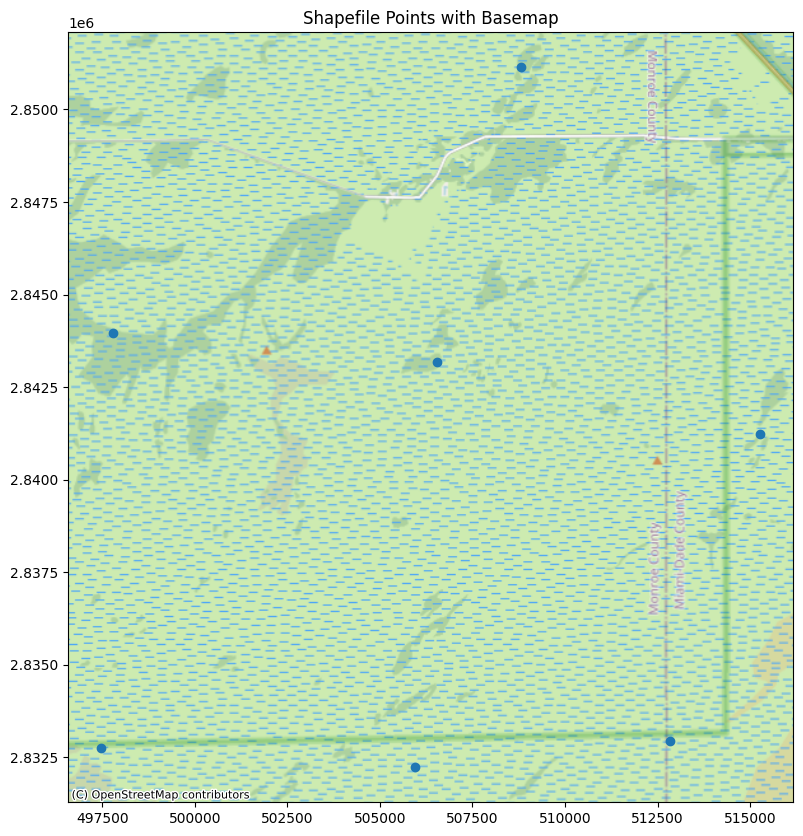

In [41]:
# Open shapefile folder
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/points_AOI1_Mask/points_AOI1.shp"
# Import geopandas and read .shp
gdf = gpd.read_file(shapefile_path)

# Get coordinates of .shp
x_coords = gdf.geometry.x
y_coords = gdf.geometry.y
coords = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
print(f"The coordinates of the .shp are: {coords}")

# Get values of the column "gridcode"
labels = gdf["gridcode"].values
# Print values
print(f"The marks and labels found in .shp are: {labels}")

ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
plt.title('Shapefile Points with Basemap')
plt.show()

# Create marks and labels using rasterize (convert vector to raster)

In [25]:
# Asegúrate de que el shapefile esté en el mismo CRS que las imágenes
with rasterio.open(os.path.join(vh_path, os.listdir(vh_path)[0])) as src:
    transform = src.transform
    raster_crs = src.crs

gdf = gdf.to_crs(raster_crs)

# Crear lista de tuplas (geometría, etiqueta)
shapes = [(geom, label) for geom, label in zip(gdf.geometry, gdf["gridcode"])]

# Rasterizar las etiquetas
raster_labels = rasterize(
    shapes,
    out_shape=(X.shape[1], X.shape[2]),  # altura y ancho
    transform=transform,
    fill=0,
    dtype="int32"
)

print("Rasterización completada. Shape:", raster_labels.shape)

Rasterización completada. Shape: (1121, 967)


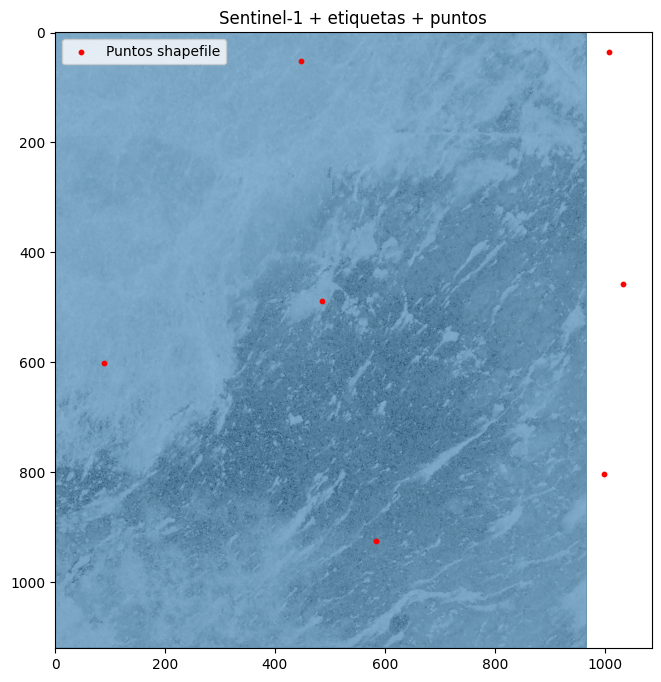

In [45]:
# Imagen base
base_image = vh_images[0]
plt.figure(figsize=(10, 8))
# Mostrar imagen Sentinel-1
plt.imshow(base_image, cmap='gray')
plt.title("Sentinel-1 + etiquetas + puntos")

# Superponer etiquetas rasterizadas
plt.imshow(raster_labels, cmap='tab10', alpha=0.5)

# Superponer puntos del shapefile
plt.scatter(
    *rasterio.transform.rowcol(transform, x_coords.values, y_coords.values),
    color='red', s=10, label='Puntos shapefile'
)

plt.legend()
plt.axis('on')
plt.show()

In [22]:
X_train = []
y_train = []

for i in range(X.shape[0]):
    img = X[i]  # (alto, ancho, 2)
    img_flat = img.reshape(-1, 2)
    labels_flat = raster_labels.flatten()
    mask = labels_flat > 0

    X_train.append(img_flat[mask])
    y_train.append(labels_flat[mask])

# Concatenar todos los datos
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f"Total muestras: {X_train.shape[0]}")

Total muestras: 203


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_tr, y_tr)
print("Accuracy RF:", rf.score(X_te, y_te))

Accuracy RF: 0.7073170731707317


deseo desarrollar un programa y código en Google Colab que utilice los frameworks Tensorflow, Keras, scikit-learn y Pytorch, para leer imágenes Sentinel-1 de un github, con carpetas separadas (VH y VV), luego utilizar las diferentes etiquetas de datos proveniente de un archivo de puntos shapefile (alojado en GitHub). Finalmente, usar los modelos para pronosticar o identificar posibles etiquetas en las imágenes S1.